# 4 Pre-Processing and Training Data

## 3.1 Contents
## 3.2 Introduction
## 3.3 Imports
## 3.4 Load Data
## 3.5 Data Exploration
## 3.6 Train/Valid Split
## 3.7 Data Modeling

## 3.2 Introduction

In the prior notebook we examined the "Historical Sales Dataset" and transformed it step-by-step into a stationary time series. This transformation allowed us to visualize the distribution, heteroskedasticity, trend and seasonality of the time series for the dealership at large and Lexus specifically. Now, it is time to use this insight to train and model for the forecasting of future sales. This notebook will begin with simple baseline models and then transition to complex models, all in the goal of using historical time series data in a statical model to forecast future vehicl sales by make and model for this population based on past results. This notebook will compare the performance and accuracy of the various models using mean absolute percentage error (MAPE). In addition, the two step-by-step transformed stationary datasets will be modeled as well for further comparison of performance and accuracy to the traditional methods used prior.  

## 3.3 Imports

In [1]:
from pandas import read_csv
import pandas as pd
import numpy as np
from numpy import array
import seaborn as sns
from pandas import datetime
import os
import itertools
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import boxcox,skew
from pmdarima.arima import auto_arima
from math import sqrt
from matplotlib.pylab import rcParams
from multiprocessing import cpu_count
from joblib import Parallel,delayed
from warnings import catch_warnings,filterwarnings

<ipython-input-1-378b7888371c>:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## 3.4 Load Data

In [2]:
#read csv file for "TotalSales" df in subdirectory'processed'  
ts = read_csv('../data/processed/TotalSales.csv')
ts['ContractYearMonth'] = pd.to_datetime(ts['ContractYearMonth'])
ts['ContractYearMonth'] = ts['ContractYearMonth'].dt.strftime('%Y-%m') #remove -01 from date
ts

,ContractYearMonth,TotalSales
0,2004-06,53
1,2004-07,53
2,2004-08,79
3,2004-09,64
4,2004-10,81
...,...,...
149,2016-11,37
150,2016-12,52
151,2017-01,36
152,2017-02,33


In [3]:
#read pickle object for stationary objects in subdirectory'processed'
ds = pd.read_pickle('../data/processed/dlrshp_stationary.pkl')
ls = pd.read_pickle('../data/processed/lexus_stationary.pkl')

## 3.6 Data Exploration

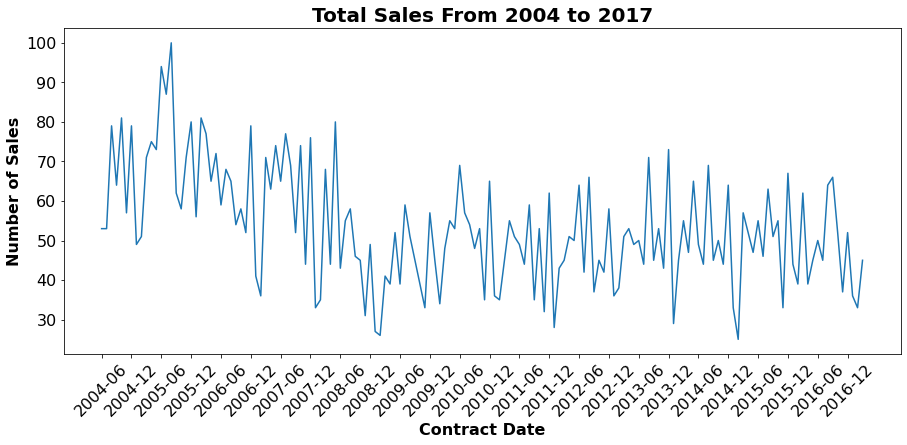

In [4]:
#graph time plot of data to examine vehicle sales yearly/monthly
fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(ts['ContractYearMonth'], ts['TotalSales'])
x_ticks = np.arange(0,153,6) #start at index 0, stop at 153, and step up by 6
plt.xticks(x_ticks, rotation = 45)

ax.set_title('Total Sales From 2004 to 2017', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Contract Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Number of Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

Text(0.5, 0.98, 'Total Dealership Sales Decomposition')

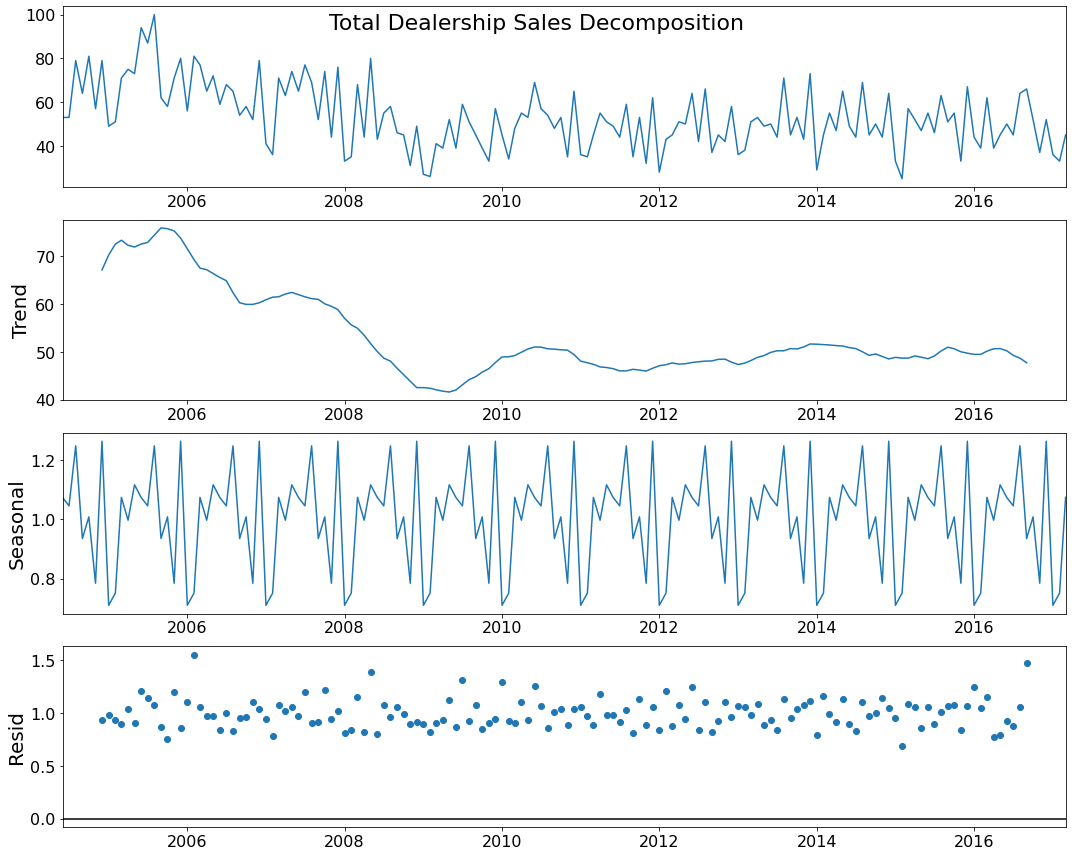

In [5]:
#convert "df_total_sales" ContractYearMonth to a pandas DatetimeIndex
ts['ContractYearMonth'] = pd.to_datetime(ts['ContractYearMonth'])
ts_index = ts.set_index('ContractYearMonth')

#multiplicative model decomposition plot
rcParams['figure.figsize'] = 15, 12
rcParams['axes.labelsize'] = 20
rcParams['ytick.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
decomposition = sm.tsa.seasonal_decompose(ts_index, model='multiplicative')
decomp = decomposition.plot()
decomp.suptitle('Total Dealership Sales Decomposition', fontsize=22)

We can see from the plots above that the series has a clear downward trend and easonality which suggests that the time series is non-stationary. However, lets confirm so in this notebook using the ADFuller test.

## 3.7 Data Modeling

To confirm that the "ts" dataset is non-stationary we will be performing an ADF Test using the following: **The null hypothesis:** the time series is non-stationary. **The alternative hypothesis:** the time series is stationary.

In [6]:
result = adfuller(ts_index['TotalSales'].ffill(0))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.586742
p-value: 0.095768
Critical Values:
	1%: -3.478
	5%: -2.882
	10%: -2.578


Since the p-value (0.09) is greater than the significance level [0.05] then the null hypothesis is accepted stating the time series is indeed non-stationary and the alternative hypthesis rejected. Therefore, we need to apply differencing to the time series to make it stationary. We will do so by setting the (d) parameter of the ARIMA model to 1.

## 3.5 Train/Test Split

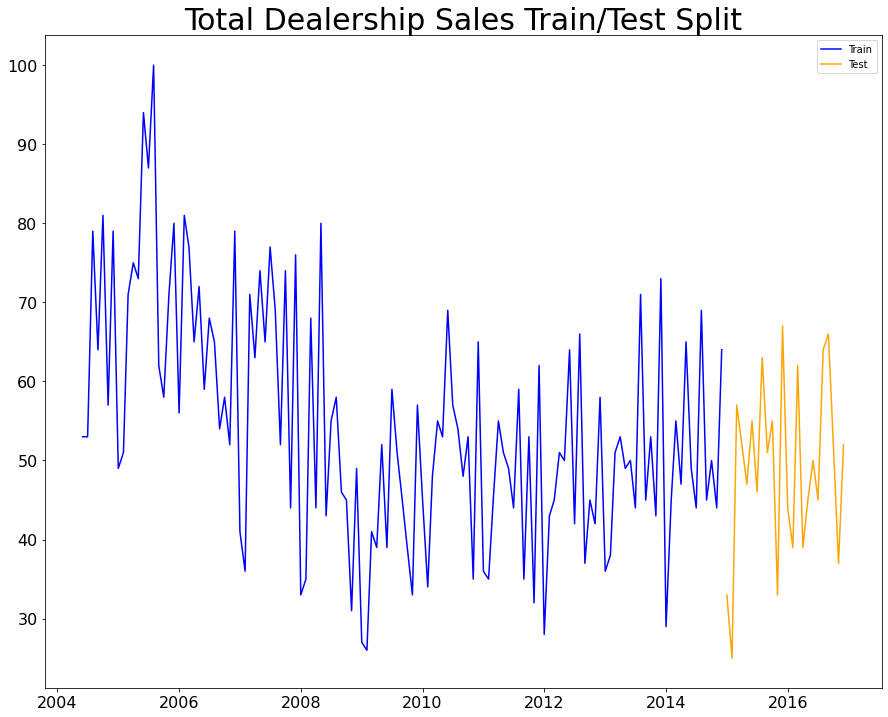

In [7]:
#divide "ts" df into train and test set
train = ts_index['2004':'2014']
test = ts_index['2015':'2016']

#plot train/valid split
plt.plot(train, 'blue', test,'orange')
plt.legend(["Train","Test"])
plt.title('Total Dealership Sales Train/Test Split', fontsize=30)
plt.show() 

### 3.6.1 Seasonal Auto-Regressive Integrated Moving Average (SARIMAX) Model

A ARIMA model is a class of statistical models for analyzing and forecasting time series data. It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts. The 'AR' stands for "autoregression, the 'I' for "integrated, and the 'MA' for "moving average. Each of these components are explicitly specified in the model as a parameter.

The parameters of the ARIMA model are defined as follows: (p) is the number of autoregressive lags, (d) is the order of differencing required to make the series stationary, and (q) is the number of moving average lags. However, we know this data has seasonality as well, so the Seasonal ARIMA model SARIMAX will be used to account for seasonal differencing. Therefore, the model we will use is represented by SARIMAX(p,d,q)(P,D,Q)m
where(P,D,Q)m represents the seasonal parameter of (p,d,q) and (m) the the number of time steps for a single seasonal period. Since the time series is observed monthly, (m) will be set to 12, representing each month of a year.

Now, we need to decide the order of each of these parameters for a SARIMAX model. To do so, we will use a custom fuction within that can obtain a recommended order for us.

### Parameter Estimation

In [8]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

#generate models with various parameter and print their AIC value
parameters=[]
aic_array=[]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
            parameters.append(str(param)+str(param_seasonal))
            aic_array.append(results.aic)
        except: 
            continue

best_parameters=parameters[aic_array.index(min(aic_array))]
print("Best parameters with lowest AIC is SARIMAX"+best_parameters)

/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:1376.1743647183434
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:1141.428855990883
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:909.6974883284868
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:785.0952360662969
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:921.6543929052725


/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/py

ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:881.6211911520745
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:794.4300448588637
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:780.7342297795348
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:1269.9692502163582


/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/py

ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:1056.089355729077
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:890.2313789894968
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:773.44413894501


/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/py

ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:913.9198368513308
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:865.6784163096535


/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:791.7572574919478
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:772.7675628779979
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:1080.8460897412485
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:932.1314068365583


/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/py

ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:934.3165842165412
ARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC:801.925098177027
ARIMA(0, 1, 0)x(1, 0, 0, 12) - AIC:923.056097482334
ARIMA(0, 1, 0)x(1, 0, 1, 12) - AIC:912.3415673439723


/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/py

ARIMA(0, 1, 0)x(1, 1, 0, 12) - AIC:820.9440141091285
ARIMA(0, 1, 0)x(1, 1, 1, 12) - AIC:814.5665368798815
ARIMA(0, 1, 1)x(0, 0, 0, 12) - AIC:990.2510018106665


/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/py

ARIMA(0, 1, 1)x(0, 0, 1, 12) - AIC:861.4002910759707
ARIMA(0, 1, 1)x(0, 1, 0, 12) - AIC:884.5932659948456
ARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC:718.6211928070445


/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/py

ARIMA(0, 1, 1)x(1, 0, 0, 12) - AIC:873.3831046897537
ARIMA(0, 1, 1)x(1, 0, 1, 12) - AIC:839.9072521785788
ARIMA(0, 1, 1)x(1, 1, 0, 12) - AIC:752.4984230499998


/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/py

ARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC:737.760530939378
ARIMA(1, 0, 0)x(0, 0, 0, 12) - AIC:1087.4136233834463
ARIMA(1, 0, 0)x(0, 0, 1, 12) - AIC:935.7252368228529
ARIMA(1, 0, 0)x(0, 1, 0, 12) - AIC:895.4633727311589


/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/py

ARIMA(1, 0, 0)x(0, 1, 1, 12) - AIC:774.6502324747554
ARIMA(1, 0, 0)x(1, 0, 0, 12) - AIC:888.2996418962222
ARIMA(1, 0, 0)x(1, 0, 1, 12) - AIC:872.0980065844534


/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/py

ARIMA(1, 0, 0)x(1, 1, 0, 12) - AIC:776.8900371892025
ARIMA(1, 0, 0)x(1, 1, 1, 12) - AIC:776.428739632594
ARIMA(1, 0, 1)x(0, 0, 0, 12) - AIC:1000.7387087297142


/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/py

ARIMA(1, 0, 1)x(0, 0, 1, 12) - AIC:868.9836185890412
ARIMA(1, 0, 1)x(0, 1, 0, 12) - AIC:879.7333037684913


/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 0, 1)x(0, 1, 1, 12) - AIC:731.7536042580643
ARIMA(1, 0, 1)x(1, 0, 0, 12) - AIC:871.2306898902528


/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 0, 1)x(1, 0, 1, 12) - AIC:847.2411319667297
ARIMA(1, 0, 1)x(1, 1, 0, 12) - AIC:750.6004660900758


/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 0, 1)x(1, 1, 1, 12) - AIC:733.7299896258968
ARIMA(1, 1, 0)x(0, 0, 0, 12) - AIC:1018.1201285796596
ARIMA(1, 1, 0)x(0, 0, 1, 12) - AIC:883.7744037644384
ARIMA(1, 1, 0)x(0, 1, 0, 12) - AIC:900.2577709004811


/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/py

ARIMA(1, 1, 0)x(0, 1, 1, 12) - AIC:736.16768390077
ARIMA(1, 1, 0)x(1, 0, 0, 12) - AIC:875.6830067130886
ARIMA(1, 1, 0)x(1, 0, 1, 12) - AIC:857.4069455737018


/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/py

ARIMA(1, 1, 0)x(1, 1, 0, 12) - AIC:755.8825473797872
ARIMA(1, 1, 0)x(1, 1, 1, 12) - AIC:757.8626696266044
ARIMA(1, 1, 1)x(0, 0, 0, 12) - AIC:989.157262339743


/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/py

ARIMA(1, 1, 1)x(0, 0, 1, 12) - AIC:859.6362558568217
ARIMA(1, 1, 1)x(0, 1, 0, 12) - AIC:886.0290334139827


/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC:704.4313332307825
ARIMA(1, 1, 1)x(1, 0, 0, 12) - AIC:863.6525234750761


/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(1, 0, 1, 12) - AIC:838.0003888116147
ARIMA(1, 1, 1)x(1, 1, 0, 12) - AIC:734.5256612507303


/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(1, 1, 1, 12) - AIC:728.3141252520805
Best parameters with lowest AIC is SARIMAX(1, 1, 1)(0, 1, 1, 12)


According to the output from out custom SARIMAX function the best parameters with the lowest AIC for our SARIMAX model is (1,1,1)(0,1,1)[12] with a AIC of 704.4313332307825. Now, lets fit these parameters to our SARIMAX model and run it.  

### Best Fit SARIMAX Model

/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/martelltardy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


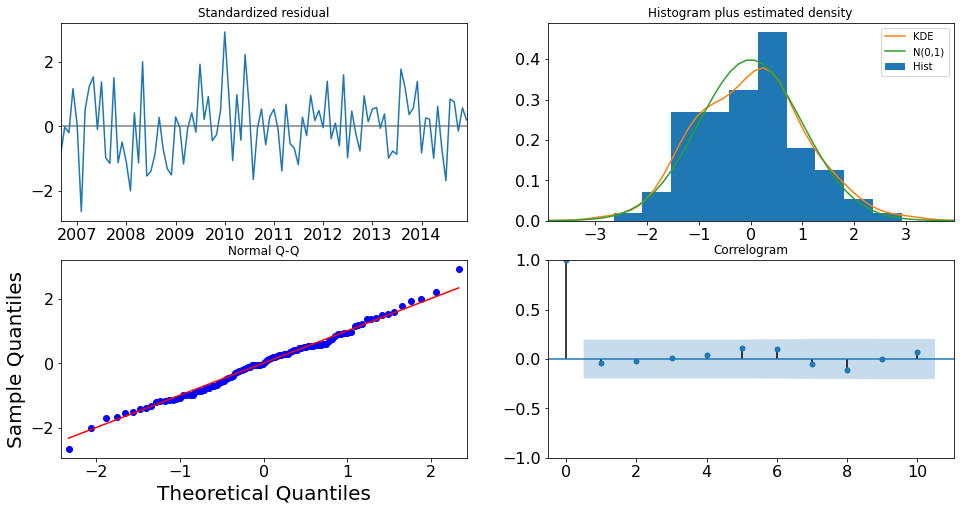

In [9]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_fit = mod.fit(disp=False)

#model diagnostics
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

It is not perfect, however, our model diagnostics suggests that the model residuals are near normally distributed.

### SARIMAX Model Predictions

Mean Squared Error: 69.99600785451797
Root Mean Squared Error: 8.36636168561448
Mean Absolute Error: 6.354965082898073


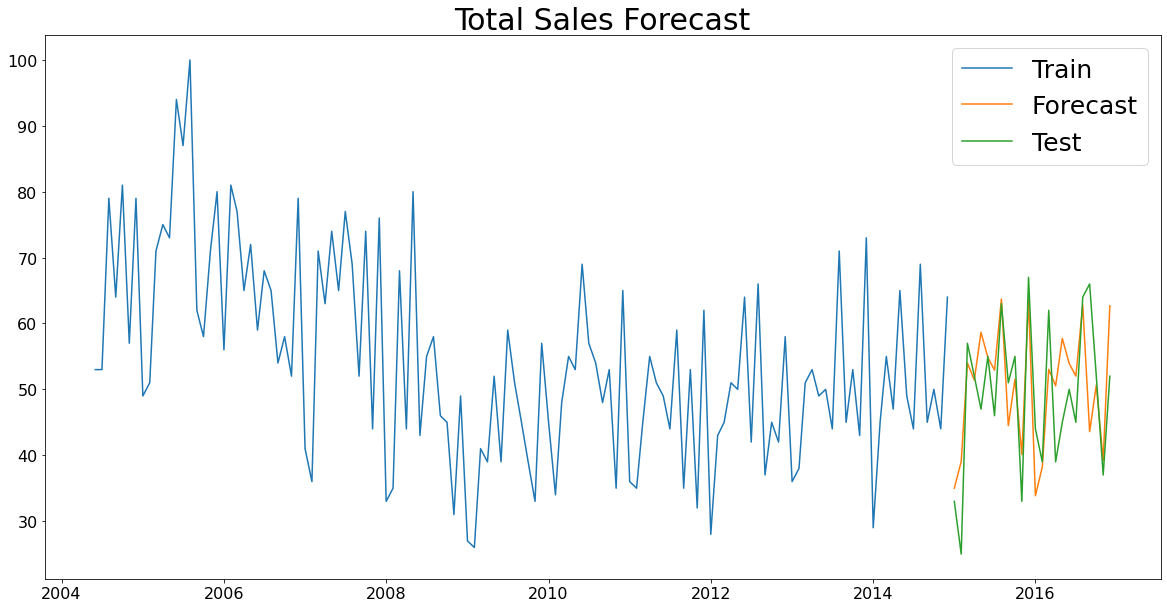

In [10]:
fcast_len = len(test)
fcast = model_fit.forecast(fcast_len)
mse = mean_squared_error(test, fcast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, fcast)
plt.figure(figsize=(20, 10))
plt.title('Total Sales Forecast', fontsize=30)
plt.plot(train, label='Train')
plt.plot(fcast, label='Forecast')
plt.plot(test, label='Test')

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
plt.legend(fontsize=25)
plt.show()

### SARIMAX Model Evaluation Using MAPE

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well. To be sure of the model's accuracy we will now compute the MAPE value.

### 3.6.2 Holt-Winter's Exponential Smoothing Model (Holt-Winter's Method)

A Holt-Winter's Method (a.k.a. Triple Exponential Smoothing Model) extends Holt to allow the forecasting of time series data that has both trend and seasonality. A Holt-Winter's Exponential Smoothing Model subsumes single and double exponential smoothing by the configuration of the nature of the trend (additive, multiplicative, or none) and the nature of the seasonality (additive, multiplicative, or none), as well as any dampening of the trend.

In this section, 
we will develop a framework for grid searching exponential smoothing model hyperparameters for our given univariate time series. 

Running the block of code below is relatively slow given the large amount of data. Model configurations and the RMSE will be printed as the models are evaluated. The top three model configurations and their error will be reported at the end of the run.

In [13]:
#one-step Holt Winter’s Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
    #define model
    history = array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    #fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    #make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

#root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

#split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

#walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    #split dataset
    train, test = train_test_split(data, n_test)
    #seed history with training dataset
    history = [x for x in train]
    #step over each time-step in the test set
    for i in range(len(test)):
        #fit model and make forecast for history
        yhat = exp_smoothing_forecast(history, cfg)
        #store forecast in list of predictions
        predictions.append(yhat)
        #add actual observation to history for the next loop
        history.append(test[i])
    #estimate prediction error
    error = measure_rmse(test, predictions)
    return error

#score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    #convert config to a key
    key = str(cfg)
    #show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        #one failure during model validation suggests an unstable config
        try:
            #never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    #check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

#grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
        #execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    #remove empty results
    scores = [r for r in scores if r[1] != None]
    #sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

#create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None]):
    models = list()
    #define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    #create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

if __name__ == '__main__':
    #load dataset
    series = read_csv('../data/processed/TotalSales.csv', header=0, index_col=0)
    ts['ContractYearMonth'] = pd.to_datetime(ts['ContractYearMonth'])
    ts_index = ts.set_index('ContractYearMonth')
    data = ts_index
    #data split
    n_test = data['2015':'2016']
    #model configs / seasonal could be 0, 3, 6, or 12 months
    cfg_list = exp_smoothing_configs(seasonal=[0,3,6,12])
    #grid search
    scores = grid_search(data, cfg_list, n_test)
    print('done')
    #list top 3 configs
    for cfg, error in scores[:3]:
        print(cfg, error)


KeyboardInterrupt: 

We can see that the best result out of the top three is an RMSE of about 7.65 degrees with the following configuration:

**Trend:** Multiplicative,
**Damped:** True,
**Seasonal:** Additive,
**Seasonal Periods:** 12,
**Box-Cox Transform:** True,
**Remove Bias:** False

In [ ]:
#once correct params are known from the output above then enter those params here.
rcParams['figure.figsize'] = 15, 7

df = read_csv('../data/processed/TotalSales.csv')
df.index = pd.date_range(start='2004-06', periods=154, freq='M')
df = df.drop(columns=['ContractYearMonth'])
df.index.freq = 'M'
train, test = df[:int(0.7*(len(df)))], df[int(0.7*(len(df))):]
# model = ExponentialSmoothing(params).fit()
model = ExponentialSmoothing(train, trend='mul', seasonal='add', seasonal_periods=12, damped=True)
hw_model = model.fit(optimized=True, use_boxcox=True, remove_bias=False)
pred = hw_model.predict(start=test.index[0], end=test.index[-1])

#plot prediction using model
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.legend(loc='best');

We will now calculate MAPE to check to accuracy of our model.

#### Checking Holt-Winter's Method Performance Using MAPE

In [ ]:
print("The MAPE for the Holt-Winter's Method is", MAPE(test, pred))

# CONCLUSION

The performance of the models on the test data is summarized below:
1. ARIMA Model: MAPE of unknown
2. Holt-Winter's Method: MAPE of 24.4%

So far, the ARIMA model has outperformed the other model by producing the lowest MAPE of 18.6%.

# Save Data